In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
import re
from scipy.spatial import distance
from scipy.stats import zscore
from scipy.stats import zmap
%matplotlib inline

dir = r"D:\2024-01-08_ALC6_day4"
data_path = os.path.join(dir, '02-processed')
npy_path = os.path.join(dir, '00-npy files')
raw_path = os.path.join(dir, '01-raw')

mouse = 'ALC6'
h5_path = os.path.join('D:/np_analysis', f'{mouse}.h5')


In [22]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [9]:
spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)

goodSamples = np.array(spikeDict['goodSamples'])
goodSpikes = np.array(spikeDict['goodSpikes'])
goodTimes = np.array(spikeDict['goodTimes'])
sampleRate = np.array(spikeDict['sampleRate'])
depths = np.array(spikeDict['depths'])
clusterIDs = np.array(spikeDict['clusterIDs'])

Number of neurons passing the quality check: 338
Sampling frequency: 30000 Hz.


In [148]:
def importnpy(dir):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `mechTrialForce` - array of all successfully recorded trials and their forces
        3. `mechTrials` - int of the number of successfully recorded mech trials
        

        ## Not yet implemented
        

    """
    import os
    import numpy as np
    import re

    data_path = os.path.join(dir, '02-processed').replace('\\', '/')
    npy_path = os.path.join(dir, '00-npy files').replace('\\', '/')
    raw_path = os.path.join(dir, '01-raw').replace('\\', '/')


    def mechTrialForce ():
        npy_files = [item for item in os.listdir(npy_path)]
        mech_files = [file for file in npy_files if 'mC_ai_data' in file]
        
        #1 sorting function to extract trial forces
        def sort_key(file):
            match = re.search(r'_(\d+).npy$', file)
            return int(match.group(1)) if match else float('inf')

        # Sort the mech trial files using the custom sorting function
        sorted_files = sorted(mech_files, key=sort_key)

        #extract forces in the proper trial order
        npy_Forces = []
        for sorted_file in sorted_files:
            match = re.search(r'_(\d+)mN_', sorted_file)
            force = int(match.group(1)) if match else None
            npy_Forces.append(force)
            


        #2 Extract trial numbers from successfully recorded mech trials (OpenEphys)
        recording_path = os.path.join(raw_path, '1-mechanical').replace('\\', '/')
        recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
        recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

        # regex search of recordings for successfully recorded mech trials
        pattern = re.compile(r'recording(\d+)')
        successfulRecordings = []
        for recording in recordings:
            match = pattern.search(recording)
            if match:
                successfulRecordings.append(int(match.group(1)))

        # sort/return successfulRecordings list
        successfulRecordings = sorted(successfulRecordings)

        #list and export the forces for only the successfully recorded mech trial files
        mechTrialForce = [npy_Forces[i - 1] for i in successfulRecordings]
        

        return mechTrialForce

    def getMechDuration():
        #This function estimates the trial duration for mechanical stimulation trials for the given experimental dataset
        
        #Empty list will contain filepaths of recordings that are to be concatenated
        mech_files = []

        #01-raw contains folders for every experiment
        experiments = [item for item in os.listdir(raw_path) if os.path.isdir(os.path.join(raw_path, item))]

        for experiment in experiments:

            if experiment == '1-mechanical':
                #files_to_concat.append(path)
                recording_path = os.path.join(raw_path, experiment).replace('\\', '/')
                recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
                recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

                for recording in recordings:
                    path = os.path.join(recording_path, recording,'continuous','Neuropix-PXI-100.ProbeA-AP','continuous.dat').replace('\\', '/')
                    mech_files.append(path)
            else:
                pass
        
        #Calculate average recording lengths
        sample_lengths = []
        for file in mech_files:
            try:
                # Get the length of the binary data
                file_size = os.path.getsize(file)
                if file_size >= 4: # Just in case I get a wildly low value from an aborted recording (e.g., ALC6, day2)
                    sample_lengths.append((file_size/30000/385/2))
            except FileNotFoundError:
                print(f"File '{file}' not found.")
            except Exception as e:
                print(f"An error occurred: {e}")
        mechDuration = np.mean(sample_lengths)
        return mechDuration
    

    try:
        mech_trial_force = mechTrialForce()
        hasMech = True
    except FileNotFoundError:
        hasMech = False
        pass
    except Exception as e:
        hasMech = False
        print("An error occurred:", e)


    #Exports
    outDict = {}
    outDict['sampleRate'] = sampleRate
    if hasMech:
        try:
            outDict['mechTrialForce'] = mech_trial_force
            outDict['mechTrials'] = len(mech_trial_force)
            outDict['mechDuration'] = getMechDuration()
        except Exception as e:
            print("An error occurred:", e)


    return outDict

In [147]:
npyDict = importnpy(dir)

mechTrialForce = npyDict['mechTrialForce']
mech_duration = npyDict['mechDuration']


print(mechTrialForce)
print(len(mechTrialForce))
print(mech_duration)

[100, 100, 200, 200, 200, 50, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 50, 50, 200, 200, 50, 50, 100, 200, 200, 100, 200, 100, 50, 200, 50, 50, 50, 50, 100, 50, 100, 50, 200, 200, 100, 50, 100, 50, 200, 100, 100, 100, 50, 200, 50, 50, 100, 100, 200, 200, 50, 200, 100, 200, 50, 200, 200, 50, 200, 200, 50, 100, 200, 100, 100, 100, 50, 200, 50, 100, 100, 50, 200, 50, 100, 50, 100, 100, 100, 100, 100, 100, 50, 50, 100, 200, 50, 100, 200, 100, 100, 50, 50, 50, 50, 200, 100, 200, 50, 50, 200, 50, 100, 100, 200, 50, 50, 200, 100, 50, 50, 100, 50, 200, 200, 50, 50, 100, 100, 200, 100, 50, 100, 200, 200, 200, 200, 50, 100, 100, 100, 200, 200, 50, 100, 200, 200, 200, 50, 50, 200, 100, 50, 100, 200, 100, 50, 200, 200, 200, 50, 50, 200, 50, 200, 50, 100, 200, 100, 50, 100, 200]
168
4.998565079365079


In [135]:
import os

file_path = r"D:\2024-01-03_ALC6_day1\01-raw\1-mechanical\recording2\continuous\Neuropix-PXI-100.ProbeA-AP\continuous.dat"
size = os.path.getsize(file_path)

print(size)

115315200


In [149]:
## Process and save h5 files with all spike data for each mouse.

# Get list of files to be analyzed
dp_pattern = re.compile(r'ALC\d_day\d')
datapoint_files = [filename for filename in os.listdir('D:/') if dp_pattern.search(filename)]

# Helper function to save acquired data in h5 file for each mouse as you get it
def save_data_to_group(group, data_name, data):
    if data_name in group:
        print(f'{data_name} already exists for data group {group}.')
        
    else:
        group[data_name] = data


# Core loop to load through each datapoint file
for filename in datapoint_files:
    #initialize filepath names
    dir = f"D:/{filename}"
    data_path = os.path.join(dir, '02-processed')
    npy_path = os.path.join(dir, '00-npy files')
    raw_path = os.path.join(dir, '01-raw')

    # Extract mouse_name and exp_day
    pattern = r"_([A-Za-z0-9]+)_(day\d+)"
    match = re.search(pattern, dir)
    if match:
        mouse_name = match.group(1)
        exp_day = match.group(2)
    else:
        print("Pattern not found in the 'dir' string.")
    print(f'Processing {mouse_name}, {exp_day}...')

    # Import Phy data
    spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)
    goodSamples = np.array(spikeDict['goodSamples'])
    goodSpikes = np.array(spikeDict['goodSpikes'])
    goodTimes = np.array(spikeDict['goodTimes'])
    sampleRate = np.array(spikeDict['sampleRate'])
    depths = np.array(spikeDict['depths'])
    clusterIDs = np.array(spikeDict['clusterIDs'])

    # Import NPY-saved data
    npyDict = importnpy(dir)
    if len(npyDict) > 1:
        mechTrialForce = npyDict['mechTrialForce']
        mech_duration = npyDict['mechDuration']
        hasMech = True
    else:
        hasMech = False

    # Create data dict to-be-saved
    data_to_save = {
        'sampleRate': sampleRate,
        'goodSpikes': goodSpikes,
        'goodSamples': goodSamples,
        'goodTimes': goodTimes,
        'depths': depths,
        'clusterIDs': clusterIDs,
        # 'selected_units': selected_units,
        # 'selected_unit_depths': selected_unit_depths,
        # 'cortical_selected_units': cortical_selected_units,
        # 'thalamic_selected_units': thalamic_selected_units,
        # Add more datasets as needed
    }
    if hasMech:
        data_to_save['mech_duration'] = mech_duration
        data_to_save['mechTrialForce'] = mechTrialForce
    
    # Save to h5 file
    savename = mouse_name
    h5_path = os.path.join('D:/np_analysis', f'{savename}.h5')

    with h5py.File(h5_path, 'a') as file:
        # Create or update the group for the current mouse
        if exp_day in file:
            exp_group = file[exp_day]
        else:
            exp_group = file.create_group(exp_day)

        # Create or update datasets for the additional data
        for data_name, data in data_to_save.items():
            save_data_to_group(exp_group, data_name, data)
    
    print(f'Data for {mouse_name}, {exp_day} saved successfully.')

print('Data proccessing complete.')

Processing ALC6, day1...
Number of neurons passing the quality check: 201
Sampling frequency: 30000 Hz.
Data for ALC6, day1 saved successfully.
Processing ALC4, day1...
Number of neurons passing the quality check: 198
Sampling frequency: 30000 Hz.
Data for ALC4, day1 saved successfully.
Processing ALC4, day2...
Number of neurons passing the quality check: 315
Sampling frequency: 30000 Hz.
Data for ALC4, day2 saved successfully.
Processing ALC6, day2...
Number of neurons passing the quality check: 169
Sampling frequency: 30000 Hz.
Data for ALC6, day2 saved successfully.
Processing ALC4, day3...
Number of neurons passing the quality check: 245
Sampling frequency: 30000 Hz.
Data for ALC4, day3 saved successfully.
Processing ALC6, day3...
Number of neurons passing the quality check: 214
Sampling frequency: 30000 Hz.
Data for ALC6, day3 saved successfully.
Processing ALC4, day4...
Number of neurons passing the quality check: 319
Sampling frequency: 30000 Hz.
Data for ALC4, day4 saved succes

In [150]:
## Diplay an h5 file's structure.
with h5py.File(h5_path, 'r') as file:
    # List all groups and datasets in the root
    print("Groups in the root:")
    for group in file:
        print(group)
    
    print('\nDatasets in each group:')
    for dataset in file['day4']:
        print(f' -{dataset}')
    # # Remove a group (replace 'group_to_remove' with your group name)
    # group_to_remove = 'ALC6_day4'
    # if group_to_remove in file:
    #     del file[group_to_remove]
    #     print(f"\n'{group_to_remove}' has been removed.")
    # else:
    #     print(f"\n'{group_to_remove}' not found.")

Groups in the root:
day1
day2
day3
day4

Datasets in each group:
 -clusterIDs
 -depths
 -goodSamples
 -goodSpikes
 -goodTimes
 -mechTrialForce
 -mech_duration
 -sampleRate


In [151]:
def loadDataDictH5(filepath):
    with h5py.File(filepath, 'r') as hdf5_file:
        # Create an empty dictionary to store data for each group
        data_dict = {}

        # Iterate through each group in the HDF5 file
        for group_name in hdf5_file.keys():
            group = hdf5_file[group_name]

            # Create a dictionary to store arrays for the current group
            group_data = {}

            # Iterate through each dataset in the group
            for dataset_name in group.keys():
                array_data = group[dataset_name][...]
                group_data[dataset_name] = array_data

            # Add the group_data dictionary to the main data_dict
            data_dict[group_name] = group_data
        
        return data_dict

In [152]:
## Load H5 file and create a data_dict in working memory
alc6_dict = loadDataDictH5(h5_path)

data_dict = alc6_dict
expts = data_dict.keys()

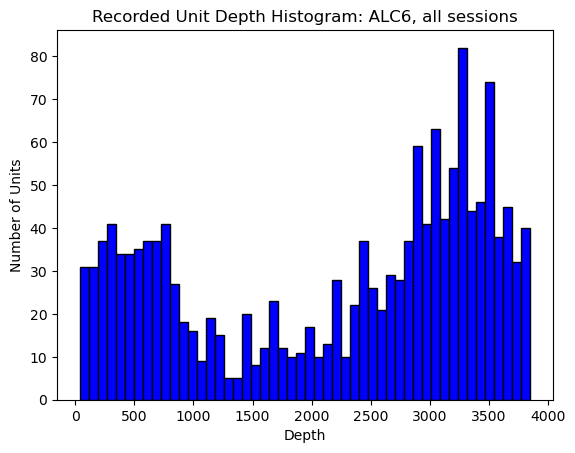

In [153]:
# Plotting depths of every recorded unit
all_depths = []

for expt in expts:
    depths = np.array(data_dict[expt]['depths'])
    all_depths.extend(depths)

# Plotting the histogram
plt.hist(all_depths, bins=50, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Number of Units')
plt.title('Recorded Unit Depth Histogram: ALC6, all sessions')

# Display the histogram
plt.show()

## 0.2 Plotting for mechanical stimultion

In [154]:
def loadExperiment(expt, data_dict):
    goodSamples = np.array(data_dict[expt]['goodSamples'])
    goodSpikes = np.array(data_dict[expt]['goodSpikes'])
    goodTimes = np.array(data_dict[expt]['goodTimes'])
    sampleRate = data_dict[expt]['sampleRate']
    depths = np.array(data_dict[expt]['depths'])
    clusterIDs = np.array(data_dict[expt]['clusterIDs'])
    mechTrialForce = np.array(data_dict[expt]['mechTrialForce'])
    mech_duration = data_dict[expt]['mech_duration']
    
    return goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration

4.962373652694611
4.998516155419223
4.998287179487179
4.998565079365079


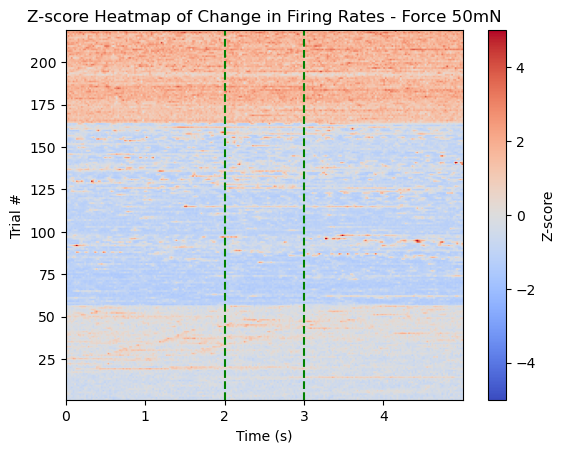

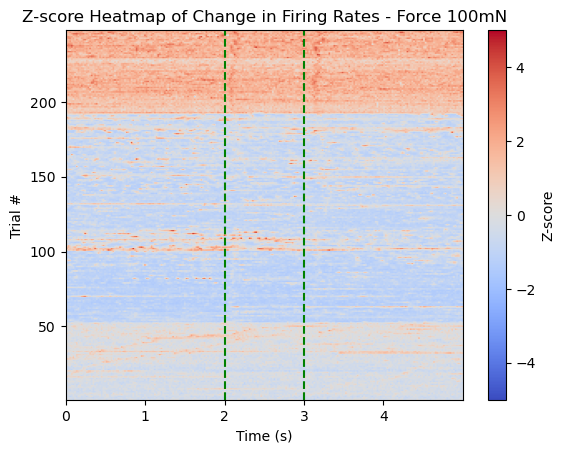

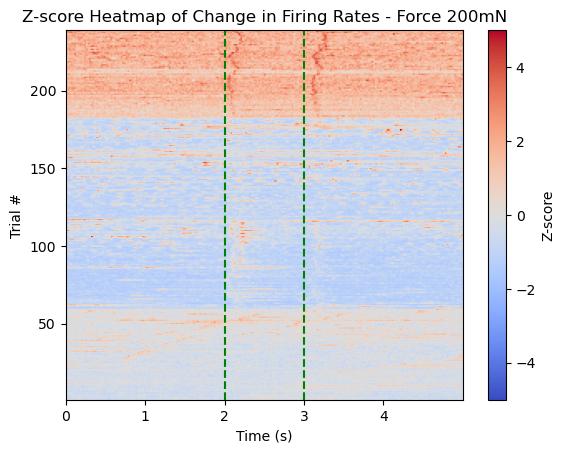

In [157]:
## Plot all mech trials (separated by force)

# Define trial parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
mech_duration = 4.8
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram


total_trials = 0
change_in_firing_rates_list = []
baseline_firing_rates_list = []
all_mechTrialForce = []


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration = loadExperiment(expt, data_dict)

    # Number of trials and bins
    num_trials = len(mechTrialForce)
    total_trials += num_trials
    all_mechTrialForce.extend(mechTrialForce)

    print(mech_duration)

    # Initialize arrays to store firing rates and stimulation signal
    change_in_firing_rates = np.zeros((num_trials, num_bins))
    baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for i in range(num_trials):
        start_index = i * int(sampleRate * mech_duration)
        end_index = (i + 1) * int(sampleRate * mech_duration)

        # Find indices within range
        trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        
        # Store firing rates for each trial
        change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
        baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]
    
    change_in_firing_rates_list.append(change_in_firing_rates)
    baseline_firing_rates_list.append(baseline_firing_rates)

all_change_in_firing_rates = np.concatenate(change_in_firing_rates_list)
all_baseline_firing_rates = np.concatenate(baseline_firing_rates_list)

# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(all_mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(all_mechTrialForce == force)[0]
    force_change_in_firing_rates = all_change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = all_baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Plotting
    time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}mN')
    plt.show()

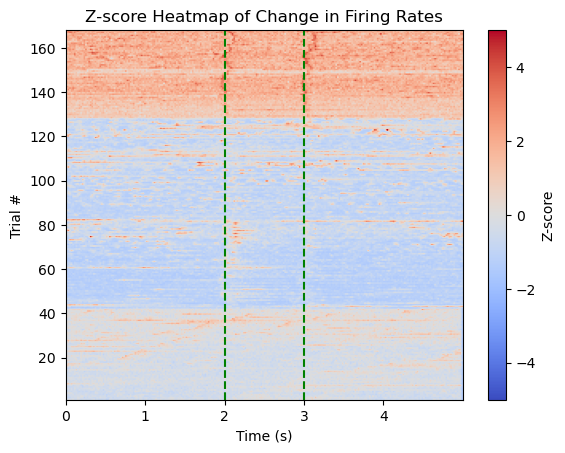

In [146]:
#Plot all mech trials (unseparated by force)
# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

#takes about 1.5 minutes

[  7  14  24  35  38  48  53  56  71  84  99 110 124 125 148 160 179 181
 182 187 196 202 204 214 239 240 241 248 315 327 333 344 347 353 356 368
 372 375 377 378 379 386 405 411 418 420 430 432 439 440 447 468 470 488
 504 505 536 557 562 571 582 612 634 640 642 643 646 647 648 655 662 670
 671 678 681 683 685 691 701 702 705 708 709 712 713 725 726 731 734 740
 745 771 773]


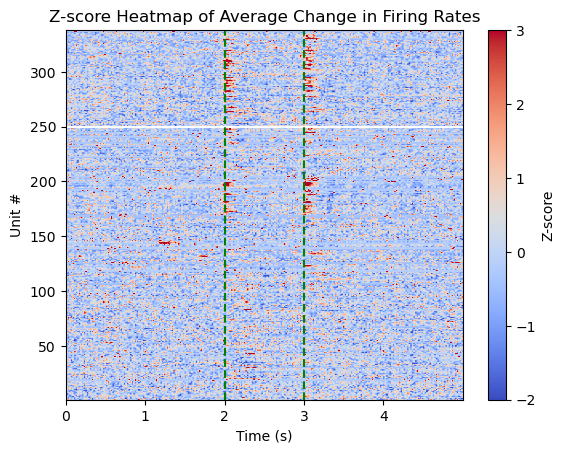

In [15]:
#Plot all mech trials (separated by force)
# Define trial parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(goodSpikes)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * mech_duration)
        end_index = (j + 1) * int(sampleRate * mech_duration)

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)

# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)

plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-2, vmax=3)  # Centered colormap


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')


# Extract units with z-scores over 2 between 1.9 and 2.1 seconds and plot z-maps
time_window_start = int(2 / bin_factor)
time_window_end = int(2.4 / bin_factor)
selected_units = unique_units[np.any(z_scored_change[:, time_window_start:time_window_end] > 3, axis=1)].astype(int)

print(selected_units)
plt.show()


In [16]:
#get an array of the depths of selected_units that can be referenced to split later by depth (cortical vs thalamic)
# Create a boolean mask for goodSpikes in clusterIDs
bool_mask = np.isin(clusterIDs, selected_units)
# Use the mask to extract depths for goodSpikes
selected_unit_depths = depths[bool_mask].astype(int)

cortical_selected_units = selected_units[selected_unit_depths < 2000]
thalamic_selected_units = selected_units[selected_unit_depths >= 2000]
print(cortical_selected_units)
print(thalamic_selected_units)

[248 315 327 333 344 347 353 356 368 372 375 377 378 379 386 405 411 418
 420 430 432 439 440 536 557 562 571 582 612 643 647 655 662 670 671 678
 681 683 685 691 701 702 705 708 709 712 713 725 726 734 740 773]
[  7  14  24  35  38  48  53  56  71  84  99 110 124 125 148 160 179 181
 182 187 196 202 204 214 239 240 241 447 468 470 488 504 505 634 640 642
 646 648 731 745 771]


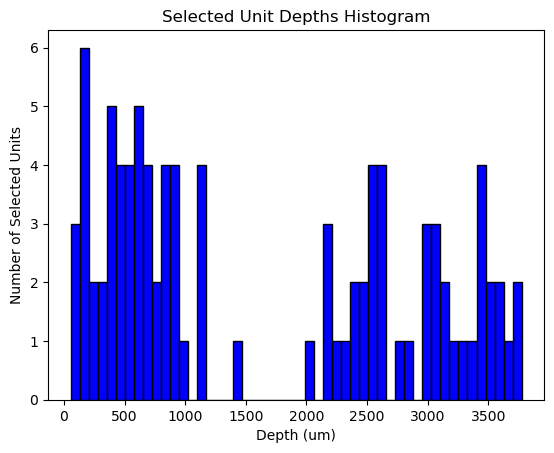

In [17]:
# Plotting the histogram
plt.hist(selected_unit_depths, bins=50, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth (um)')
plt.ylabel('Number of Selected Units')
plt.title('Selected Unit Depths Histogram')

# Display the histogram
plt.show()

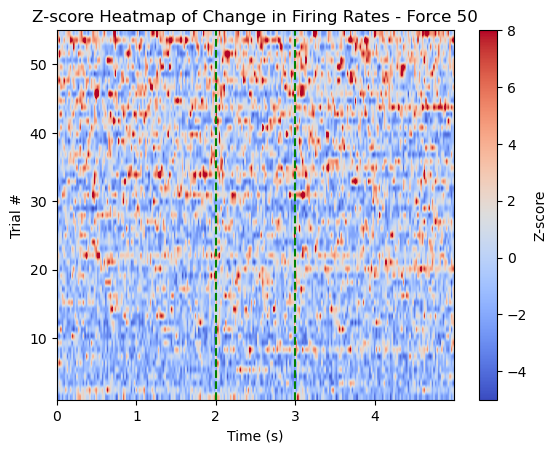

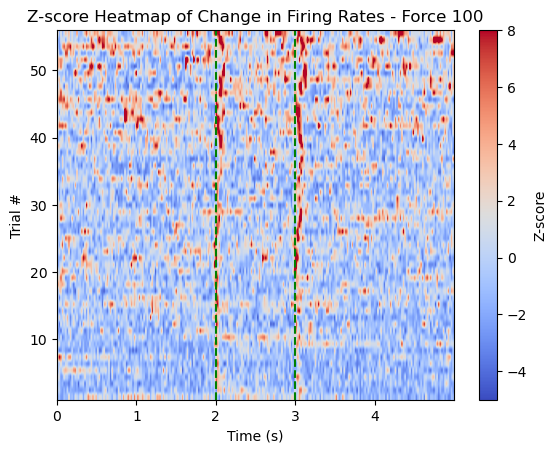

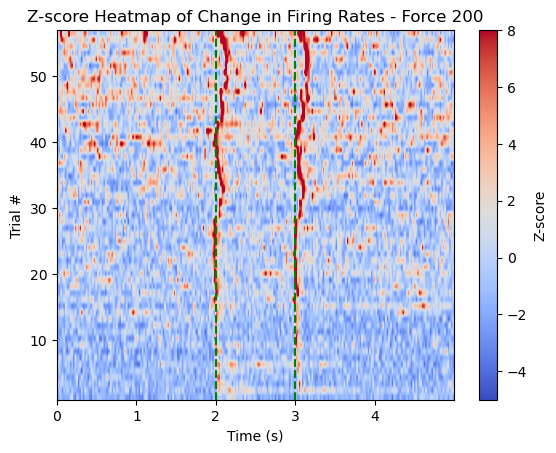

In [354]:
#plot mech trials with enriched units

#Plot all mech trials (separated by force)
# Define trial parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(mech_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(mech_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * mech_duration)
    end_index = (i + 1) * int(sampleRate * mech_duration)

    #Find indices within range
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]



# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(mechTrialForce)

for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(mechTrialForce == force)[0]
    force_change_in_firing_rates = change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    #z_scored_change = (change_in_firing_rates - baseline_firing_rates.mean(axis=0, keepdims=True)) / baseline_firing_rates.std(axis=0, ddof=1, keepdims=True)

    
    # Plotting
    time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=8)  # Centered colormap

    

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}')    
    plt.show()

    #print(baseline_firing_rates[:,0])

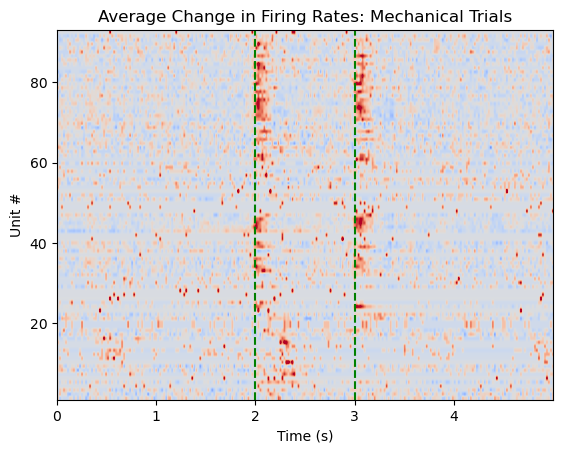

In [404]:
#Plot all mech trials (separated by force)
# Define trial parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * mech_duration)
        end_index = (j + 1) * int(sampleRate * mech_duration)

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.mean(z_scored_change, axis=0)
std_dev_z_score = np.std(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)

plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
# plt.fill_between(time_axis,
#                  average_z_score - std_dev_z_score,
#                  average_z_score + std_dev_z_score,
#                  color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Firing Rates: Mechanical Trials')

plt.show()


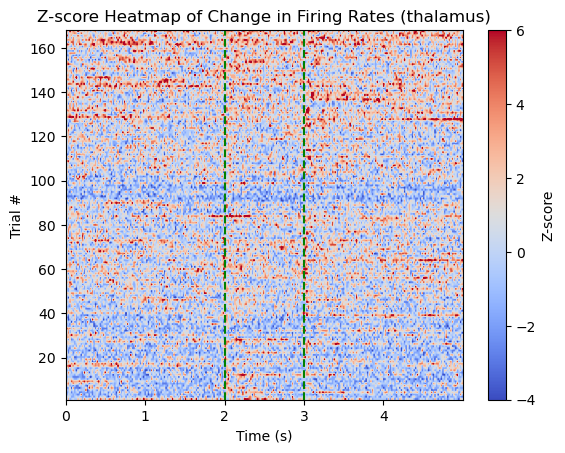

In [323]:
#Plot specified mech trials (unseparated by force)

#Plot all mech trials (separated by force)
# Define trial parameters
mech_duration = 4.9985  # seconds
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
units_to_plot = thalamic_selected_units

# Number of trials
num_trials = len(mechTrialForce)
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(mech_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(mech_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * mech_duration)
    end_index = (i + 1) * int(sampleRate * mech_duration)

    #Find indices within range
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, units_to_plot)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in the first 2 seconds
    baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

# Z-score the change in firing rates
#z_scored_change = zscore(change_in_firing_rates, axis=1)
z_scored_change = zmap(change_in_firing_rates, baseline_firing_rates, axis=0)

# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-4, vmax=6)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates (thalamus)')
plt.show()

In [ ]:
#How to open stored data

# Open the HDF5 file in read mode
with h5py.File('data_multimice.h5', 'r') as file:
    # Initialize an empty list to store the goodSpikes data
    all_goodSpikes = []

    # Iterate over mice
    for mouse_name in file.keys():
        # Check if 'goodSpikes' dataset exists in the current mouse group
        if 'goodSpikes' in file[mouse_name]:
            # Append the goodSpikes data to the list
            all_goodSpikes.append(np.array(file[mouse_name]['goodSpikes']))

    # Concatenate all goodSpikes data to create a single array
    combined_goodSpikes = np.concatenate(all_goodSpikes, axis=0)

# Now, combined_goodSpikes contains all the goodSpikes data from each mouse
print(combined_goodSpikes)

## 0.4 Plotting for physio experiment

In [29]:
settings = {
    'task_name' : 'acquireRecField',

    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording
    
    'Fs': 30000,  # in samples/s
    'xV': 7.8, # in V.
    'yV': 3.2, # in V.

    'stepV' : .05, # in Volts. Increment of voltage to be stepped for mirror
    'time_per_region' : 0.03, # in seconds. Duration to hold mirrors in place for each region
    'trial_repeats' : 10 # number of times each region should be sampled (default = 10)
}


# set mirror x_out and y_out arrays within the specified voltage range and increments
xminV = settings['xV'] - 0.5
xmaxV = settings['xV'] + 0.5
yminV = settings['yV'] - 0.5
ymaxV = settings['yV'] + 0.5
x_out_values = np.arange(xminV, xmaxV, settings['stepV'])
y_out_values = np.arange(yminV, ymaxV, settings['stepV'])

# create matrix for all possible combinations of x_out and y_out
all_combinations = np.array(np.meshgrid(x_out_values, y_out_values)).T.reshape(-1, 2)
trial_duration = len(all_combinations**2) * settings['time_per_region'] * settings['trial_repeats'] # in seconds
print(trial_duration*30000)

3780000.0


In [276]:
settings = {
    'task_name' : 'physiologicalLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'trace_oi' : 4, # number (X) for trace of interest from "SA-LTMR example traces/saltmr_trace{X}.npy"
    'laser_duration' : 0.0003,  # seconds
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}

# calculate trial_duration and load example trace_array
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))
print(trial_duration)

trace_array = np.load(r'C:\Users\aewor\Documents\GitHub\NP_Analysis\NP_Optical\SA-LTMR example traces\saltmr_trace{}.npy'.format(settings['trace_oi']))
# Assign trains of laser pulses in the same firing pattern as the trace_array empirical template
train_onsets = np.arange((settings['trial_buffer']), trial_duration, ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']
laser_onsets = np.round(trace_array * settings['Fs']).astype(int)

print(train_onsets)
print(laser_onsets)

277.0
[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
[  342   737  1137  1574  3133  4118  4672  5851  7837  8130  8568  9518
 11116 11554 12052 14364]


In [ ]:
settings = {
    'task_name' : 'pulsedLaser',
    
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : 7.8, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : 3.2, # in Volts. Fixed voltage for mirror's y-axis

    'laser_duration' : 0.0003,  # seconds
    'laser_frequency' : 40, # Hz (for sustained pulse, equate to settings['Fs']). **Run 5, 20, and 40Hz for full set**
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pass (100 takes ~10 minutes; default = 50)
}


# calculate trial_duration
trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration']))

train_onsets = np.arange((settings['trial_buffer']), trial_duration, ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']

intervals = []

for i in range(len(train_onsets)-1):
    interval = train_onsets[i+1] - train_onsets[i]
    intervals.append(interval)

print(train_onsets)
print(trial_duration*30000)
print(np.unique(intervals))
print(165000/30000)

[  30000.  195000.  360000.  525000.  690000.  855000. 1020000. 1185000.
 1350000. 1515000. 1680000. 1845000. 2010000. 2175000. 2340000. 2505000.
 2670000. 2835000. 3000000. 3165000. 3330000. 3495000. 3660000. 3825000.
 3990000. 4155000. 4320000. 4485000. 4650000. 4815000. 4980000. 5145000.
 5310000. 5475000. 5640000. 5805000. 5970000. 6135000. 6300000. 6465000.
 6630000. 6795000. 6960000. 7125000. 7290000. 7455000. 7620000. 7785000.
 7950000. 8115000. 8280000.]
8310000.0
[165000.]
5.5


In [234]:
physio = r"D:\2024-01-03_ALC6_day1\00-npy files\physioLaser_20240103_134825_ao_data.npy"
physfile = np.load(physio)
print(len(physfile[0]))
print(((len(physfile[0])/30000)-2)/5)

8160000
54.0


In [235]:
acrec = r"D:\2024-01-03_ALC6_day1\00-npy files\acRecField_20240103_134321_ao_data.npy"
acrecfile = np.load(acrec)
print(len(acrecfile[0]))
print(((len(acrecfile[0])/30000)-2)/5)

3600000
23.6


In [20]:
try:
    mech_duration = len(mechTrialForce) * 4.998 * 30000 #duration in samples
except TypeError:
    #if len(mechTrialForce is incalculable, it is a length of 0)
    mech_duration = 0 * mech_duration * 30000 #duration in samples

acRecField_duration = 3600000 #duration in samples
physio_duration = 8160000 #duration in samples

physio_start = mech_duration + acRecField_duration #start sample number
physio_end = physio_start + physio_duration #end sample number

intertrial_buffer = int(1.03 * 30000)
physio_start_index = physio_start + intertrial_buffer  #add in buffer time


pulse_start = physio_start + physio_duration
pulse_end = pulse_start + physio_duration
print(physio_start_index)


28820820.0


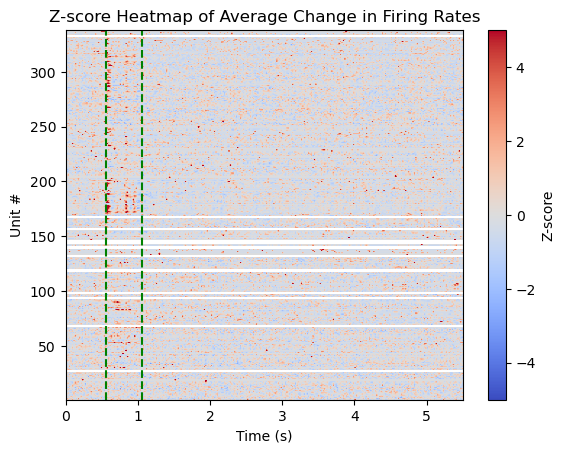

In [333]:
#physio trial z-score calculations plotted by UNIT
# Define trial parameters
laser_duration = 5.5  # seconds
stim_onset = 0.55  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds



# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram


unique_units = np.unique(goodSpikes)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + physio_start_index
        end_index = (j + 1) * int(sampleRate * laser_duration) + physio_start_index

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)

plt.imshow(z_scored_change, aspect='auto', extent=[0, laser_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap
# plt.plot(time_axis, z_scored_change.T)


# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Average Change in Firing Rates')


plt.show()


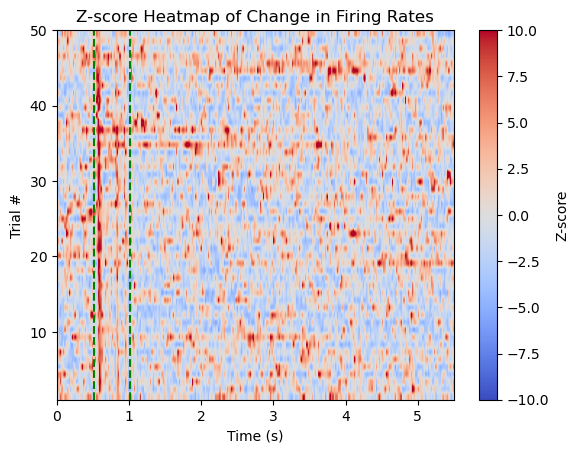

In [327]:
#physio trial z-score calculations
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * laser_duration) + physio_start_index
    end_index = (i + 1) * int(sampleRate * laser_duration) + physio_start_index

    #trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]
    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

# Z-score the change in firing rates
#z_scored_change_phys = zscore(change_in_firing_rates, axis=1)
z_scored_change_phys = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change_phys, aspect='auto', extent=[0, laser_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-10, vmax=10)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

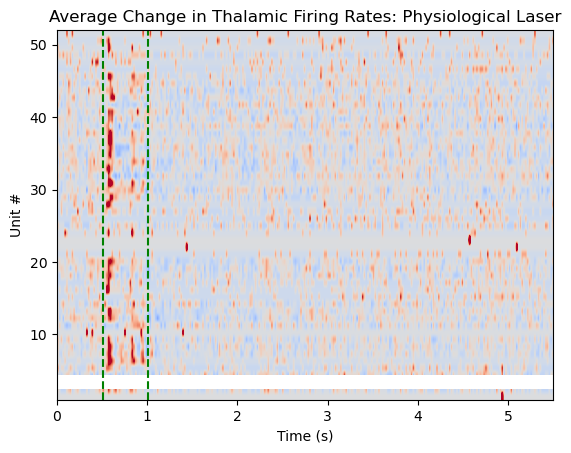

In [24]:
#Plot all mech trials (separated by force)
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(cortical_selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + physio_start_index
        end_index = (j + 1) * int(sampleRate * laser_duration) + physio_start_index

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.nanmean(z_scored_change, axis=0)
std_dev_z_score = np.nanstd(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)


plt.imshow(z_scored_change, aspect='auto', extent=[0, laser_duration, 1, len(unique_units)],
           cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
# plt.fill_between(time_axis,
#                  average_z_score - std_dev_z_score,
#                  average_z_score + std_dev_z_score,
#                  color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Thalamic Firing Rates: Physiological Laser')

plt.show()


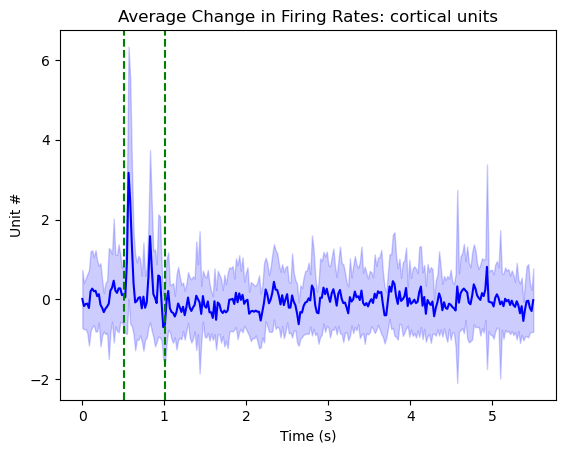

In [ ]:
#Plot all mech trials (separated by force)
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(cortical_selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + physio_start_index
        end_index = (j + 1) * int(sampleRate * laser_duration) + physio_start_index

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.nanmean(z_scored_change, axis=0)
std_dev_z_score = np.nanstd(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)


# plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
#            cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
plt.fill_between(time_axis,
                 average_z_score - std_dev_z_score,
                 average_z_score + std_dev_z_score,
                 color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Firing Rates: cortical units')

plt.show()


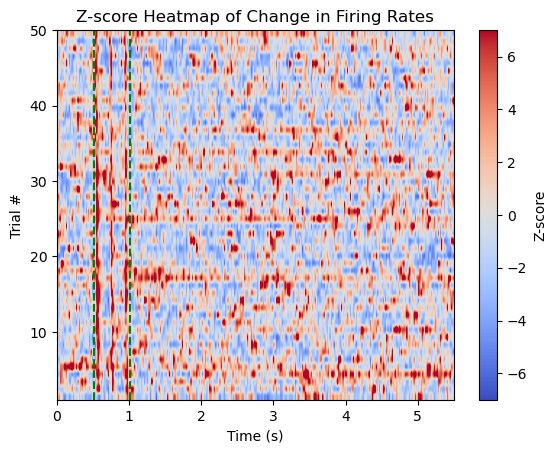

In [328]:
#5Hz pulse trial z-score calculations
# Define trial parameters
laser_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * laser_duration) + pulse_start + intertrial_buffer
    end_index = (i + 1) * int(sampleRate * laser_duration) + pulse_start + intertrial_buffer

    #trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

# Z-score the change in firing rates
#z_scored_change_5 = zscore(change_in_firing_rates, axis=1)
z_scored_change_5 = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change_5, aspect='auto', extent=[0, laser_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-7, vmax=7)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = 15342/30000
hold_duration = 0.5
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

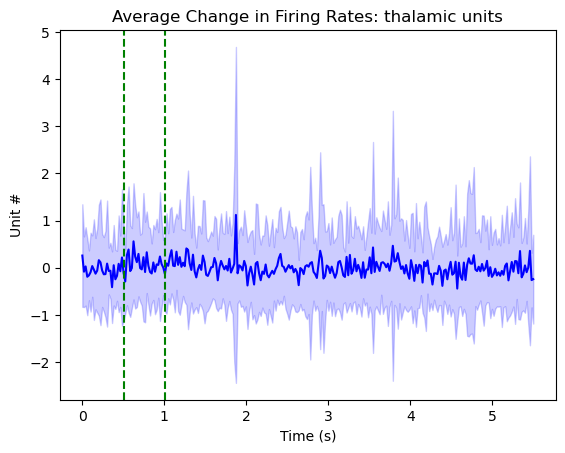

In [393]:
#Plot all mech trials (separated by force)
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(thalamic_selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + pulse_start + intertrial_buffer
        end_index = (j + 1) * int(sampleRate * laser_duration) + pulse_start + intertrial_buffer

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.nanmean(z_scored_change, axis=0)
std_dev_z_score = np.nanstd(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)


# plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
#            cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
plt.fill_between(time_axis,
                 average_z_score - std_dev_z_score,
                 average_z_score + std_dev_z_score,
                 color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Firing Rates: thalamic units')

plt.show()


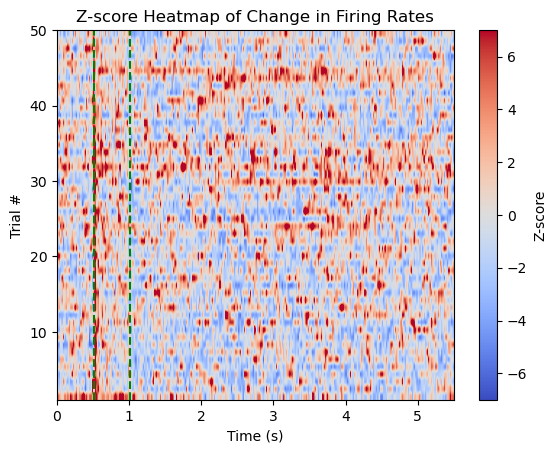

In [329]:
#20Hz pulse trial z-score calculations
# Define trial parameters
laser_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * laser_duration) + pulse_start + physio_duration + intertrial_buffer
    end_index = (i + 1) * int(sampleRate * laser_duration) + pulse_start + physio_duration + intertrial_buffer

    #trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

# Z-score the change in firing rates
#z_scored_change_20 = zscore(change_in_firing_rates, axis=1)
z_scored_change_20 = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change_20, aspect='auto', extent=[0, laser_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-7, vmax=7)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = 15342/30000
hold_duration = 0.5
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

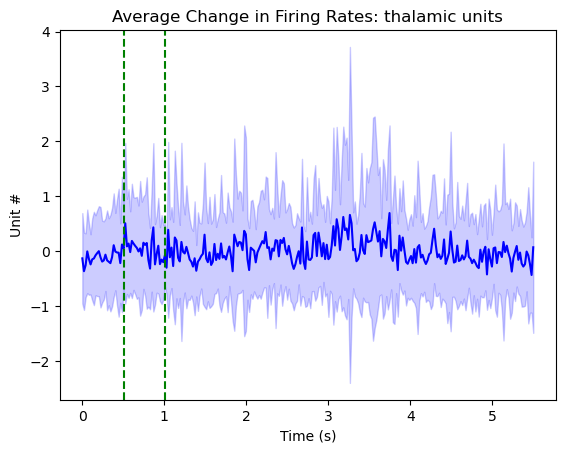

In [396]:
#Plot all mech trials (separated by force)
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(thalamic_selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + pulse_start + physio_duration + intertrial_buffer
        end_index = (j + 1) * int(sampleRate * laser_duration) + pulse_start + physio_duration + intertrial_buffer

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.nanmean(z_scored_change, axis=0)
std_dev_z_score = np.nanstd(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)


# plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
#            cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
plt.fill_between(time_axis,
                 average_z_score - std_dev_z_score,
                 average_z_score + std_dev_z_score,
                 color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Firing Rates: thalamic units')

plt.show()


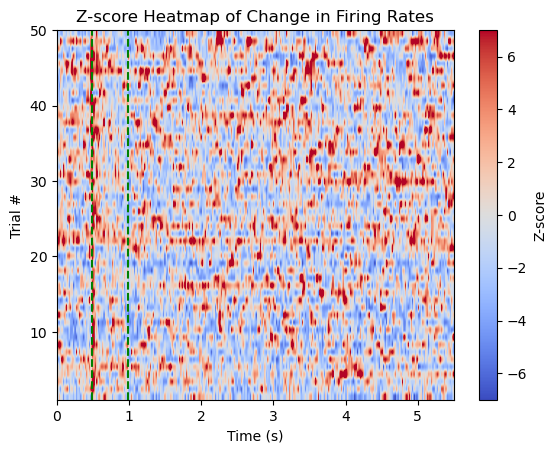

In [332]:
#40Hz pulse trial z-score calculations
# Define trial parameters
laser_duration = 5.5  # seconds
stim_onset = 0.1  # second
stim_ramp_down = 0.6  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))
baseline_firing_rates = np.zeros((num_trials, int(laser_duration / bin_factor) - 1))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * laser_duration) + pulse_start + (2*physio_duration) + intertrial_buffer
    end_index = (i + 1) * int(sampleRate * laser_duration) + pulse_start + (2*physio_duration) + intertrial_buffer

    #trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

    trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

    # Calculate the average firing rate in from 2 seconds to the end
    baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor) - 1:])
    baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
    baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]

# Z-score the change in firing rates
#z_scored_change_40 = zscore(change_in_firing_rates, axis=1)
z_scored_change_40 = zmap(change_in_firing_rates, baseline_firing_rates, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change_40, aspect='auto', extent=[0, laser_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-7, vmax=7)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = 14500/30000
hold_duration = 0.5
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

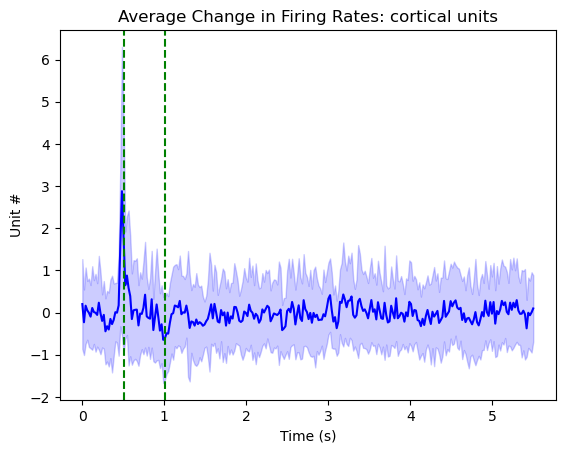

In [398]:
#Plot all mech trials (separated by force)
# Define trial parameters
laser_duration = 5.5  # seconds
stimulation_onset = 15342/30000
hold_duration = 0.5


# Number of trials
num_trials = 50
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_duration / bin_factor) - 1 # Number of bins for the histogram

#Plot z-scores separated by individual units in y-axis
unique_units = np.unique(cortical_selected_units)

# Initialize arrays to store average change in firing rates for each unit
average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

# Process each unit
for i, unit in enumerate(unique_units):
    # Find spikes belonging to the current unit
    unit_spikes = goodSamples[goodSpikes == unit]

    # Initialize arrays to store firing rates for each trial
    unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
    unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for j in range(num_trials):
        start_index = j * int(sampleRate * laser_duration) + pulse_start + (2*physio_duration) + intertrial_buffer
        end_index = (j + 1) * int(sampleRate * laser_duration) + pulse_start + (2*physio_duration) + intertrial_buffer

        # Find spikes within the current trial
        trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

        # Store firing rates for each trial
        unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
        unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

    # Calculate the average change in firing rate for the unit
    average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
    average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

# Z-score the average change in firing rates
z_scored_change = zscore(average_change_in_firing_rates, axis=1)
average_z_score = np.nanmean(z_scored_change, axis=0)
std_dev_z_score = np.nanstd(z_scored_change, axis=0, ddof=1)

# Plotting
time_axis = np.linspace(0, laser_duration, int(laser_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(unique_units) + 1)


# plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, len(unique_units)],
#            cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

plt.plot(time_axis, average_z_score, color='blue', label='Average Z-score')
plt.fill_between(time_axis,
                 average_z_score - std_dev_z_score,
                 average_z_score + std_dev_z_score,
                 color='blue', alpha=0.2, label='±1 Stdev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title('Average Change in Firing Rates: cortical units')

plt.show()
